# Epsilon measurements on numerical datasets

The most important aspect when applying Differential Privacy to a dataset, is the selection of epsilon. This number is held accountable of the tradeoff that DP offers: how much accuracy are we going to sacrifice in order to have less privacy loss, and vice vera.

Epsilon is the most important aspect in the definition of DP. Let's revise the definition of Differential Privacy.


A randomized algorithm M with
domain $N^X$ is ($\epsilon,\delta)$-differentially private if for all $S \subseteq Range(M)$ and
for all $x, y \in N^X s.t. ||x - y||_1 \leq 1:$

$$ Pr[M(x) \in S] \leq e^\epsilon Pr[M(y) \in S] + \delta$$

Given the IBM DP library, and given the previously known dataset of surgeries in the US, we are going to measure the accuracy changes with the selection of different epsilon values. We are going to apply these measurements in different queries, thus we can have a better picture on how accurate is the application of DP in the IBM diffprivlib

## Dataset and Preprocessing

The identity of the dataset is analysed in a previous notebook, and is therefor taken for granted here. Moreover, the preprocessing of the dataset and the definition of privacy bounds (alongside with its problems), are also analysed in the basic queries ipynb, thus we are just going to do only what is neccesary here for our testings.

### Import libraries

In [1]:
import pandas as pd
import diffprivlib as dp
import numpy as np
import matplotlib.pyplot as plt

### Load and preprocess the dataset

In [2]:
DATASET = "./surgeries.csv"
df = pd.read_csv(DATASET)
# remove the $ sign from the payments
df[df.columns[4:5]] = df[df.columns[4:5]].replace('[\$,]', '', regex=True).astype(float)
df[df.columns[5:6]] = df[df.columns[5:6]].replace('[\$,]', '', regex=True).astype(float)

### Bounds' definition

As explained in the previous notebook, we can only guess the values of the bounds that we are going to pass to the DP queries, because if we just take the tuple of the highest and lowest values in the dataset, we violate the definition of differential privacy

In [3]:
total_payment_range = medicare_payment_range = (0, 1000000)

## Accuracy testings

Once again, we are going to base our accuracy testings in the following function. It applies the given query multiple times, in order to ensure the lack of extreme DP calculations (rare) which may appear due to the probabilistic distributions used.

This time, it is very important to see the accuracy changes based on a similar scale for all datasets and sizes. The way to do that, is to compute the relative error of accuracy, defined in the following function. The function below applies the given query multiple times, in order to ensure the lack of extreme DP calculations (rare) which may appear due to the probabilistic distributions used. 

In [4]:
def accuracy_error(non_dp_query, dp_query, bounds, dataset, epsilon = 1):
    # list of the error in every loop
    acc = []
    # result without dp. No need to re-compute in every loop
    res_wo_dp = non_dp_query(dataset)
    # run 100 times
    for i in range(0,100):
        # result with dp. subject to change in every loop
        res_with_dp = dp_query(dataset, bounds = bounds, epsilon = epsilon)
        # absolute error of the 2 computations
        diff = abs(res_wo_dp - res_with_dp) / res_wo_dp
        # append the error in the error list
        acc.append(diff)
    # return the mean error of our computations
    return np.mean(acc)

## Accuracy measurements using different values of epsilon

Differential Privacy is all about a trafeoff: We want to balance our privacy loss with the accuracy of the results. Below, we are going to plot the accuracy results using different epsilons while applying the same query to a fixed size dataset.

First up, we are going to test this measurement by applying a mean value query. 

In [5]:
# epsilon values we are going to run the query with
epsilon = [i/10 + 0.2 for i in range (0,50)]
# list of the accuracy results, empty in the beggining
results = []

# loop through different epsilons
for e in epsilon:
    res = accuracy_error(np.mean, dp.tools.mean, total_payment_range, df['Average Total Payments'].tolist(), epsilon = e)
    results.append(res)

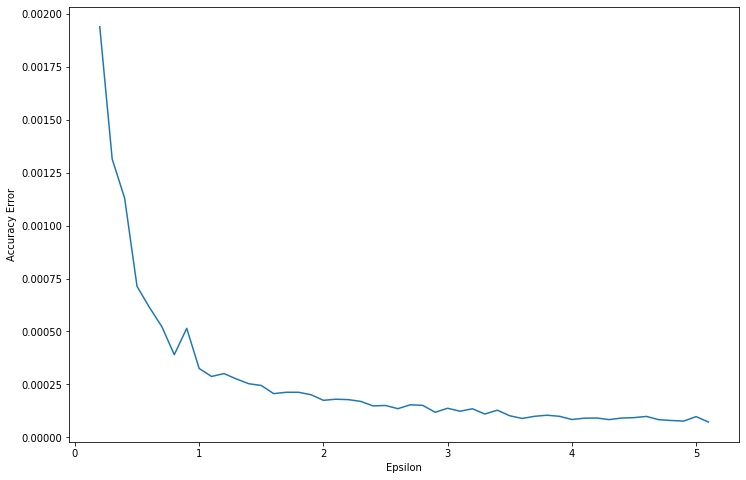

In [6]:
# plot the result 
plt.figure(figsize = (12,8))

plt.plot(epsilon, results)
plt.xlabel('Epsilon')
plt.ylabel('Accuracy Error')
plt.show()

It is clear that as we increase the epsilon value, the privacy loss gets bigger. On the other hand, if epsilon is too small, as we can see in the above plot, we are going to have extreme errors in accuracy in our queries. 

The optimal value of epsilon varies, there is no general rule for the perfect epsilon. It depends on many different aspects, such as:

- The noise generated by the probabilistic mechanism used
- The implementation of the algorithm
- The size of the dataset
- The query itself.

Moreover, the selection of epsilon depends on the dataset. For example, we might have a dataset that is extremely important to have minimal privacy loss. In that case, we will opt to use a rather small epsilon, thus we do not disclose the sensitive data included. An other dataset could be less sensitive, but the analyst might have a need for extreme accuracy every time, so the epsilon selected should be rather big.